In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import duckdb

In [3]:
df = pd.read_csv(r"/home/adarsh_r/backpack/train.csv")

#### Quick glance

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


Only **text attributes** contains null values. \
`Weight Capacity` attribute contains ~140 null values.

`laptop compartment` attribute can be converted to int 

In [5]:
df.head(10)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
5,5,Nike,Canvas,Medium,10.0,No,Yes,NaN,Black,7.241812,20.01553
6,6,Nike,NaN,Large,3.0,No,No,Backpack,Green,6.828123,84.80500
7,7,Puma,Canvas,Small,1.0,Yes,Yes,Backpack,Blue,21.488864,27.15815
8,8,Under Armour,Polyester,Medium,8.0,Yes,No,Tote,Gray,10.207780,25.98652
9,9,Under Armour,Nylon,Medium,2.0,Yes,Yes,Messenger,Pink,15.895100,38.48741


In [6]:
df["Compartments"] = df["Compartments"].astype("int")
column_attributes = df.select_dtypes(include="object").columns
df[column_attributes] = df[column_attributes].astype('category')
df = df.set_index("id")

#### Exploring Data

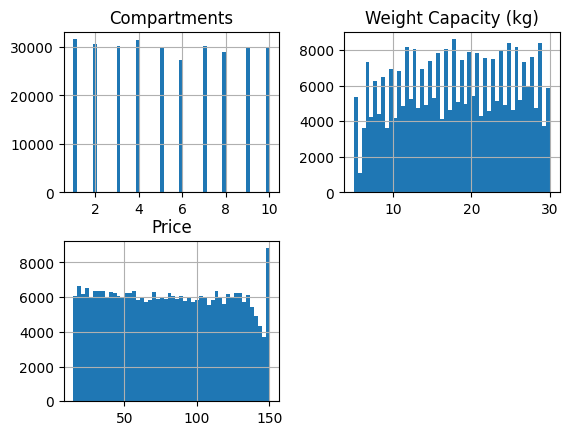

In [7]:
df[["Compartments", "Weight Capacity (kg)", "Price"]].hist(bins=50)
plt.show()

`prices` are capped at **150** \
Distributions of other attributes have roughly consistent pattern

It seems to be symmetric data

In [8]:
df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [9]:
df["Material"].unique()

['Leather', 'Canvas', 'Nylon', NaN, 'Polyester']
Categories (4, object): ['Canvas', 'Leather', 'Nylon', 'Polyester']

In [10]:
backpack_df = df.copy()

In [11]:
column_attributes = backpack_df.select_dtypes(include="object").columns
for col in column_attributes:
    ds = backpack_df[[col]].value_counts()
    plt.figure(figsize=(5,3))
    plt.bar(height = ds, x=[col[0] for col in ds.index])
    plt.title(col)
plt.show()    

Each of these categorical attributes are more or less representative of each category

In [12]:
backpack_df.select_dtypes(include="number").corr()["Price"]*100

Compartments             -0.013149
Weight Capacity (kg)      1.801820
Price                   100.000000
Name: Price, dtype: float64

#### Preparing Data

In [13]:
backpack_df.head(5)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1,Yes,Yes,Messenger,Green,17.749338,86.02312


In [14]:
backpack_df, backpack_prices = backpack_df.drop(columns=["Price"]), backpack_df["Price"].copy()

In [15]:
backpack_df_numeric = backpack_df.select_dtypes(include="number")

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [17]:
backpack_df["Color"].unique()

['Black', 'Green', 'Red', 'Blue', 'Gray', 'Pink', NaN]
Categories (6, object): ['Black', 'Blue', 'Gray', 'Green', 'Pink', 'Red']

In [18]:
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'))

cat_imputer = Pipeline([("imputation",SimpleImputer(strategy="most_frequent"))])

cat_1hot_pipeline = make_pipeline(cat_imputer, OneHotEncoder(handle_unknown="ignore"))

cat_ord_pipeline_color = make_pipeline(cat_imputer, 
                                        OrdinalEncoder(categories=[['Red', 'Pink', 'Green', 'Blue', 'Gray', 'Black']]))
cat_ord_pipeline_size = make_pipeline(cat_imputer, 
                                        OrdinalEncoder(categories=[["Small", "Medium", "Large"]]))

In [38]:
cat_1hot_attribs = ['Brand', 'Material', 'Laptop Compartment', 'Waterproof',
       'Style']

preprocessing = ColumnTransformer([
    
    ('num', num_pipeline, backpack_df_numeric.columns),
    ('cat_1hot', cat_1hot_pipeline, cat_1hot_attribs),
    ('cat_ord_size', cat_ord_pipeline_size, ["Size"]),
    ('cat_ord_color', cat_ord_pipeline_color,['Color'])
    
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                ('cat_1hot',
                                 Pipeline(steps=[('pipeline',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Brand', 'Material', 'Lapt...
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']]))]),
                                 ['Size']),
                                ('cat_ord_color',
                                 Pipeline(steps=[('pipeline',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Red',
                                                                              'Pink',
                                                                              'Green',
                                                                              'Blue',
                                                                              'Gray',
                                                                              'Black']]))]),
                                 ['Color'])])

Target attribute `Price` is capped at 150, maybe try applying StandardScaler

In [20]:
backpack_prepared = preprocessing.fit_transform(backpack_df)

In [21]:
preprocessed_df = pd.DataFrame(backpack_prepared,columns= preprocessing.get_feature_names_out())
preprocessed_df

,num__Compartments,num__Weight Capacity (kg),cat_1hot__Brand_Adidas,cat_1hot__Brand_Jansport,cat_1hot__Brand_Nike,cat_1hot__Brand_Puma,cat_1hot__Brand_Under Armour,cat_1hot__Material_Canvas,cat_1hot__Material_Leather,cat_1hot__Material_Nylon,cat_1hot__Material_Polyester,cat_1hot__Laptop Compartment_No,cat_1hot__Laptop Compartment_Yes,cat_1hot__Waterproof_No,cat_1hot__Waterproof_Yes,cat_1hot__Style_Backpack,cat_1hot__Style_Messenger,cat_1hot__Style_Tote,cat_ord_size__Size,cat_ord_color__Color
0,7.0,11.611723,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,5.0
1,10.0,27.078537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
2,2.0,16.643760,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,8.0,12.937220,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
4,1.0,17.749338,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,9.0,12.730812,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
299996,6.0,26.633182,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,3.0
299997,9.0,11.898250,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0
299998,1.0,6.175738,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


#### Model Training

In [22]:
from sklearn.metrics import root_mean_squared_error

In [23]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                ('cat_1hot',
                                 Pipeline(steps=[('pipeline',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [...
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']]))]),
                                 ['Size']),
                                ('cat_ord_color',
                                 Pipeline(steps=[('pipeline',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Red',
                                                                              'Pink',
                                                                              'Green',
                                                                              'Blue',
                                                                              'Gray',
                                                                              'Black']]))]),
                                 ['Color'])])

##### random forest regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rnd_forest = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

In [26]:
rnd_forest.fit(backpack_df, backpack_prices)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                                 ('cat_1hot',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('onehotencoder',
                                                                   OneHot...
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']]))]),
                                                  ['Size']),
                                                 ('cat_ord_color',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Red',
                                                                                               'Pink',
                                                                                               'Green',
                                                                                               'Blue',
                                                                                               'Gray',
                                                                                               'Black']]))]),
                                                  ['Color'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [27]:
rnd_forest_predictions = rnd_forest.predict(backpack_df)

In [28]:
root_mean_squared_error(rnd_forest_predictions, backpack_prices)

np.float64(47.65657)

In [29]:
#root_mean_squared_error(rnd_forest_predictions, backpack_prices)  = 15.080534072820022

15.080534072820033

In [30]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
knn_reg = make_pipeline(preprocessing, KNeighborsRegressor())

In [32]:
knn_reg.fit(backpack_df, backpack_prices)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                                 ('cat_1hot',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('onehotencoder',
                                                                   OneHot...
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']]))]),
                                                  ['Size']),
                                                 ('cat_ord_color',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Red',
                                                                                               'Pink',
                                                                                               'Green',
                                                                                               'Blue',
                                                                                               'Gray',
                                                                                               'Black']]))]),
                                                  ['Color'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [33]:
knn_predictions = knn_reg.predict(backpack_df)

In [34]:
root_mean_squared_error(knn_predictions, backpack_prices)

34.9189232061898

before below :

In [57]:
knn_rrsmes

array([42.53241862, 42.75826498, 42.75919732, 42.98090242, 42.84785742])

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
decision_tree_reg = make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42, ccp_alpha = 0.1)) #changed ccp_alpha to 0.4

In [38]:
decision_tree_reg.fit(backpack_df, backpack_prices)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                                 ('cat_1hot',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('onehotencoder',
                                                                   OneHot...
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']]))]),
                                                  ['Size']),
                                                 ('cat_ord_color',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Red',
                                                                                               'Pink',
                                                                                               'Green',
                                                                                               'Blue',
                                                                                               'Gray',
                                                                                               'Black']]))]),
                                                  ['Color'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.1, random_state=42))])

In [39]:
dt_preds = decision_tree_reg.predict(backpack_df)

In [40]:
root_mean_squared_error(dt_preds,backpack_prices)

39.01692237210562

ini-decision-tree-rsme = 0.90

decision tree performs well \
But i suspect a possible overfitting

In [41]:
dt3_reg = make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42, ccp_alpha = 0.7))

In [42]:
dt3_reg.fit(backpack_df, backpack_prices)
dt3_predictions = dt3_reg.predict(backpack_df)
root_mean_squared_error(dt3_predictions, backpack_prices)

39.02825262986854

In [43]:
dt2_reg = make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42, ccp_alpha = 0.3))


##### cv for decision tree

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
decision_tree_rsmes = - cross_val_score(decision_tree_reg, backpack_df, backpack_prices, cv=5, scoring='neg_root_mean_squared_error')

In [47]:
decision_tree_rsmes

array([38.86665163, 39.06867892, 38.97245002, 39.10088578, 39.08362517])

In [55]:
decision_tree_rsmes.mean()

np.float64(39.018458305383696)

##### cv for random forest

In [49]:
rnd_forest_rsmes = - cross_val_score(rnd_forest, backpack_df, backpack_prices, cv=5, scoring='neg_root_mean_squared_error')

In [50]:
rnd_forest_rsmes

array([40.14221054, 40.26818912, 40.2693963 , 40.31533564, 40.3067348 ])

In [51]:
from sklearn.linear_model import SGDRegressor

In [52]:
sgd_reg = make_pipeline(preprocessing, SGDRegressor(random_state=42))

In [53]:
sgd_rsmes = -cross_val_score(sgd_reg, backpack_df, backpack_prices, cv=5, scoring='neg_root_mean_squared_error' )

In [54]:
sgd_rsmes

array([39.48953694, 40.77662604, 38.99202999, 39.13792638, 39.3668567 ])

##### regularized random forest regressor

In [59]:
regu_rnd_forest = make_pipeline(preprocessing, RandomForestRegressor(random_state=42, max_depth=10, min_samples_split=5))

In [68]:
regu_rnd_forest.fit(backpack_df, backpack_prices)
regu_rnd_forest_preds = regu_rnd_forest.predict(backpack_df)
root_mean_squared_error(backpack_prices, regu_rnd_forest_preds)

38.71380806677729

In [61]:
regu_rnd_forest_rsmes = -cross_val_score(regu_rnd_forest, backpack_df, backpack_prices, cv=5, scoring="neg_root_mean_squared_error")
regu_rnd_forest_rsmes

array([38.87594143, 39.08384781, 38.98188828, 39.10998226, 39.09101858])

#### Hyperparameter tuning

In [25]:
from sklearn.model_selection import GridSearchCV

In [42]:
final_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42)) 
])

In [43]:
param_grid = {
    'random_forest__max_depth': [5, 10, 15],
    'random_forest__min_samples_split': [5, 10, 20],
    'random_forest__min_samples_leaf': [2, 4, 6]
}

In [44]:
grid_search = GridSearchCV(final_pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

In [45]:
grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                                                        ('cat_1hot',
                                                                         Pipeline(steps=[('pipeline',
                                                                                          Pipeline(steps=[('imputation',
                                                                                                           SimpleImputer(strategy='most_frequent'))])),
                                                                                         ('onehotencoder',
                                                                                          OneHot...
                                                                                                           SimpleImputer(strategy='most_frequent'))])),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(categories=[['Red',
                                                                                                                      'Pink',
                                                                                                                      'Green',
                                                                                                                      'Blue',
                                                                                                                      'Gray',
                                                                                                                      'Black']]))]),
                                                                         ['Color'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'random_forest__max_depth': [5, 10, 15],
                         'random_forest__min_samples_leaf': [2, 4, 6],
                         'random_forest__min_samples_split': [5, 10, 20]},
             scoring='neg_mean_squared_error')

In [46]:
grid_search.fit(backpack_df, backpack_prices)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                                                        ('cat_1hot',
                                                                         Pipeline(steps=[('pipeline',
                                                                                          Pipeline(steps=[('imputation',
                                                                                                           SimpleImputer(strategy='most_frequent'))])),
                                                                                         ('onehotencoder',
                                                                                          OneHot...
                                                                                                           SimpleImputer(strategy='most_frequent'))])),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(categories=[['Red',
                                                                                                                      'Pink',
                                                                                                                      'Green',
                                                                                                                      'Blue',
                                                                                                                      'Gray',
                                                                                                                      'Black']]))]),
                                                                         ['Color'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'random_forest__max_depth': [5, 10, 15],
                         'random_forest__min_samples_leaf': [2, 4, 6],
                         'random_forest__min_samples_split': [5, 10, 20]},
             scoring='neg_mean_squared_error')

In [98]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__min_samples_leaf,param_random_forest__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,22.811777,1.468855,0.317181,0.000869,5,2,5,"{'random_forest__max_depth': 5, 'random_forest...",-1515.725358,-1522.385079,-1528.729941,-1522.280126,5.309618,2
1,21.537057,0.091698,0.317942,0.003022,5,2,10,"{'random_forest__max_depth': 5, 'random_forest...",-1515.725896,-1522.382593,-1528.732346,-1522.280278,5.310354,3
2,21.386726,0.171897,0.347740,0.039269,5,2,20,"{'random_forest__max_depth': 5, 'random_forest...",-1515.729344,-1522.372477,-1528.729152,-1522.276991,5.307579,1
3,21.374606,0.110377,0.319135,0.002710,5,4,5,"{'random_forest__max_depth': 5, 'random_forest...",-1515.730848,-1522.392997,-1528.727875,-1522.283907,5.306575,5
4,21.287819,0.119960,0.320636,0.003003,5,4,10,"{'random_forest__max_depth': 5, 'random_forest...",-1515.730216,-1522.390227,-1528.728476,-1522.282973,5.307059,4
5,21.336709,0.074371,0.317651,0.002575,5,4,20,"{'random_forest__max_depth': 5, 'random_forest...",-1515.733958,-1522.389601,-1528.728901,-1522.284153,5.305687,6
6,21.453030,0.071505,0.319005,0.002930,5,6,5,"{'random_forest__max_depth': 5, 'random_forest...",-1515.732086,-1522.396516,-1528.737326,-1522.288643,5.309915,8
7,21.328681,0.148833,0.319372,0.003150,5,6,10,"{'random_forest__max_depth': 5, 'random_forest...",-1515.732086,-1522.396516,-1528.737326,-1522.288643,5.309915,8
8,22.132176,0.275163,0.329631,0.006503,5,6,20,"{'random_forest__max_depth': 5, 'random_forest...",-1515.735341,-1522.395261,-1528.734936,-1522.288513,5.307599,7
9,36.953473,0.709880,0.503929,0.002562,10,2,5,"{'random_forest__max_depth': 10, 'random_fores...",-1516.494401,-1523.664770,-1529.488802,-1523.215991,5.314425,18


#### final steps

In [50]:
final_model = grid_search.best_estimator_

In [56]:
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['Compartments', 'Weight Capacity (kg)'], dtype='object')),
                                                 ('cat_1hot',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='igno...
                                                                                               'Large']]))]),
                                                  ['Size']),
                                                 ('cat_ord_color',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('imputation',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Red',
                                                                                               'Pink',
                                                                                               'Green',
                                                                                               'Blue',
                                                                                               'Gray',
                                                                                               'Black']]))]),
                                                  ['Color'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=5, min_samples_leaf=2,
                                       min_samples_split=20,
                                       random_state=42))])

In [86]:
model_test_set = pd.read_csv('/home/adarsh_r/backpack/test.csv')

In [87]:
test_set = model_test_set[['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']]

In [88]:
final_model.predict(test_set.loc[:0]).round(3)

array([81.279])

In [89]:
final_preds = final_model.predict(test_set).round(3)

In [90]:
final_preds

array([81.279, 82.444, 82.091, ..., 82.297, 81.472, 81.165],
      shape=(200000,))

In [91]:
final_preds_ds = pd.DataFrame(final_preds)

In [101]:
submission1 = pd.concat([model_test_set["id"], final_preds_ds],axis=1).rename(columns={0 : "Price"})
submission1

,id,Price
0,300000,81.279
1,300001,82.444
2,300002,82.091
3,300003,81.464
4,300004,78.498
...,...,...
199995,499995,79.730
199996,499996,79.099
199997,499997,82.297
199998,499998,81.472


In [102]:
submission1.to_csv('submission1.csv')